### Import dependencies

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

### Import plotting library

In [2]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

### Reflect Tables into SQLAlchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, and_, desc, extract

In [4]:
# create connection to database
engine = create_engine("sqlite:///data/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Model = automap_base()

In [6]:
# reflect the tables
Model.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Model.classes.keys()

['measurement', 'station']

### Save references to each table

In [8]:
# create python classes by extending the existing database models
# use a nicer representation of the class instances

class Measurement(Model):
    __tablename__ = 'measurement'

    def __repr__(self):
        return "<{}(station='{}', date='{}', prcp='{}', tobs='{}')>".\
                format(self.__class__.__name__, self.station, self.date, self.prcp, self.tobs)

class Station(Model):
    __tablename__ = 'station'

    def __repr__(self):
        return "<{}(station='{}', name='{}', latitude='{}', longitude='{}', elevation='{}')>".\
                format(self.__class__.__name__, self.station, self.name, self.latitude, self.longitude, self.elevation)


In [9]:
# reflect the tables
Model.prepare(engine, reflect=True)

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [14]:
for row  in session.query(Station).all():
    print(row.name)

WAIKIKI 717.2, HI US
KANEOHE 838.1, HI US
KUALOA RANCH HEADQUARTERS 886.9, HI US
PEARL CITY, HI US
UPPER WAHIAWA 874.3, HI US
WAIMANALO EXPERIMENTAL FARM, HI US
WAIHEE 837.5, HI US
HONOLULU OBSERVATORY 702.2, HI US
MANOA LYON ARBO 785.2, HI US


### Exploratory Climate Analysis

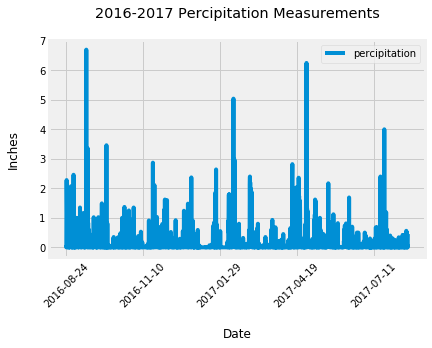

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date_reported = session.query(func.max(Measurement.date)).scalar()
last_year = datetime.strptime(last_date_reported, '%Y-%m-%d') - timedelta(365)

# Perform a query to retrieve the date and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
                  filter(Measurement.date >= last_year).\
                  all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame([ ( row.date, row.prcp ) for row in results ], 
                  columns=['date', 'percipitation'] ).set_index('date')

# Fill in any missing percipitation values with 0
df.fillna(value=0, inplace=True)

# Check if there are any duplicate records
df.reset_index().duplicated().value_counts()

# Sort the dataframe by date
df.sort_values(by='date', ascending=True, inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(title='2016-2017 Percipitation Measurements\n', rot=45)
ax.set_xlabel('\nDate')
ax.set_ylabel('Inches\n')
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df[['percipitation']].describe()

,percipitation
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
# Station table joined to get station name in query
q = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
            join(Station, Station.station == Measurement.station).\
            group_by(Measurement.station, Station.name).\
            order_by(desc(func.count(Measurement.station)))

# query database            
stations = q.all()

print(f"There are {len(stations)} stations available in this dataset.")

There are 9 stations available in this dataset.


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
counter = 0
print()
print('   ID            Rows   Name of Station')
print('   ===========   ====   =======================================')
for station in stations:
    counter += 1
    print(f'{counter}) {station[0]}   {station[2]}   {station[1]}')


   ID            Rows   Name of Station
   ===========   ====   =======================================
1) USC00519281   2772   WAIHEE 837.5, HI US
2) USC00519397   2724   WAIKIKI 717.2, HI US
3) USC00513117   2709   KANEOHE 838.1, HI US
4) USC00519523   2669   WAIMANALO EXPERIMENTAL FARM, HI US
5) USC00516128   2612   MANOA LYON ARBO 785.2, HI US
6) USC00514830   2202   KUALOA RANCH HEADQUARTERS 886.9, HI US
7) USC00511918   1979   HONOLULU OBSERVATORY 702.2, HI US
8) USC00517948   1372   PEARL CITY, HI US
9) USC00518838   511   UPPER WAHIAWA 874.3, HI US


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                  filter(Measurement.station == q.first()[0]).\
                  first()
lo_temp  = station[1]
hi_temp  = station[2]
avg_temp = station[3]

print(f'{station[0]} is the most active station with the following readings:')
print(f'Lowest Temperature Recorded  : { "{0:.2f}".format(lo_temp) }')
print(f'Highest Temperature Recorded : { "{0:.2f}".format(hi_temp) }')
print(f'Average Temperature          : { "{0:.2f}".format(avg_temp) }')

USC00519281 is the most active station with the following readings:
Lowest Temperature Recorded  : 54.00
Highest Temperature Recorded : 85.00
Average Temperature          : 71.66


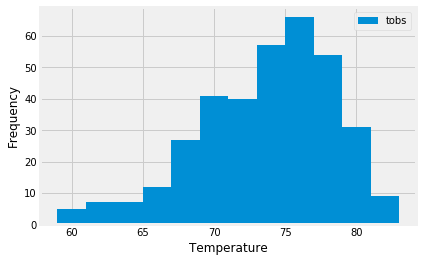

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
q = session.query(Measurement.tobs).filter(Measurement.station == stations[0][0])

# Calculate the date 1 year ago from the last data point in the database
last_date_reported = session.query(func.max(Measurement.date)).\
                             filter(Measurement.station == stations[0][0]).\
                             scalar()
last_year = datetime.strptime(last_date_reported, '%Y-%m-%d') - timedelta(365)

# Perform a query to retrieve the temperature readings
results = q.filter(Measurement.date >= last_year).all()

# Plot the data using a dataframe
plt.hist([ row[0] for row in results ], bins=12, label='tobs')
plt.ylabel('Frequency')
plt.xlabel('Temperature')
plt.legend(loc='best')
plt.show()

### Bonus Challenge Assignment

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`


In [26]:
    """Return a list of dates and temperature values observed"""
    # Calculate the date 1 year ago from the last data point in the database
    last_date_reported = session.query(func.max(Measurement.date)).scalar()
    last_year = datetime.strptime(last_date_reported, '%Y-%m-%d') - timedelta(365)

    # Query all dates and temperature values
    station = session.query(Measurement.station, func.count(Measurement.station)).\
                   group_by(Measurement.station).\
                   order_by(desc(func.count(Measurement.station))).\
                   first()[0]

    results = session.query(Measurement.date, Measurement.tobs).\
                      filter(Measurement.station == station).\
                      filter(extract('year', Measurement.date) == last_year).\
                      all()

In [33]:
session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == station).\
        filter(extract('year', Measurement.date) >= extract('year', last_year)).\
        all()

[('2016-01-01', 74.0),
 ('2016-01-02', 72.0),
 ('2016-01-03', 68.0),
 ('2016-01-04', 69.0),
 ('2016-01-05', 70.0),
 ('2016-01-06', 69.0),
 ('2016-01-07', 76.0),
 ('2016-01-08', 75.0),
 ('2016-01-09', 74.0),
 ('2016-01-10', 74.0),
 ('2016-01-11', 73.0),
 ('2016-01-12', 75.0),
 ('2016-01-13', 74.0),
 ('2016-01-14', 66.0),
 ('2016-01-15', 71.0),
 ('2016-01-16', 73.0),
 ('2016-01-17', 75.0),
 ('2016-01-18', 63.0),
 ('2016-01-19', 61.0),
 ('2016-01-20', 62.0),
 ('2016-01-21', 65.0),
 ('2016-01-22', 65.0),
 ('2016-01-23', 75.0),
 ('2016-01-24', 78.0),
 ('2016-01-25', 69.0),
 ('2016-01-26', 65.0),
 ('2016-01-27', 69.0),
 ('2016-01-28', 64.0),
 ('2016-01-29', 68.0),
 ('2016-01-30', 73.0),
 ('2016-01-31', 74.0),
 ('2016-02-01', 69.0),
 ('2016-02-02', 68.0),
 ('2016-02-03', 69.0),
 ('2016-02-04', 65.0),
 ('2016-02-05', 67.0),
 ('2016-02-06', 69.0),
 ('2016-02-07', 70.0),
 ('2016-02-08', 56.0),
 ('2016-02-09', 57.0),
 ('2016-02-10', 58.0),
 ('2016-02-11', 61.0),
 ('2016-02-12', 71.0),
 ('2016-02-